In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
import catboost as cb
import lightgbm as lgbm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.impute import  SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
import pickle
from IPython.display import display, HTML
from sklearn.feature_selection import SelectKBest, f_regression

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

file ='insurance.csv'


**Data Loading**

In [118]:
#Load csv into a dataframe
df=pd.read_csv(file)
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0,yes,southwest,16884.9240
1,18.0,male,33.77,1,no,southeast,1725.5523
2,28.0,male,33.00,3,no,southeast,4449.4620


**Data Profiling**

In [119]:
display(df.describe())
display(df.describe(include=['O']))

,age,bmi,children,charges
count,1334.000000,1336.000000,1338.000000,1338.000000
mean,39.206147,30.663866,1.094918,13270.422265
std,14.070989,6.102741,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,26.250000,26.272500,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.700000,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


We will use some pandas functions to find out more about our dataset such as the number of rows and columns, categorical and quantitative features and find if any data is missing.

In [120]:
#Get the number of rows and columns
print(f'Dataset size: {df.shape}')

Dataset size: (1338, 7)


In [121]:
#List all data types of all the columns
#df.dtypes.sort_values(ascending=True)

There are 3 categorical features - sex, smoker and region and rest of them are numeric.

We will also identify missing values for each of the features.

In [122]:
#Calculate the percentage of null values
df.isnull().sum().sort_values(ascending=False)/df.shape[0]

age         0.002990
bmi         0.001495
charges     0.000000
region      0.000000
smoker      0.000000
children    0.000000
sex         0.000000
dtype: float64

#### Data Cleaning

'age' and 'bmi' have some null values as below:

In [123]:
null_inds=df[(df.age.isnull()) | (df.bmi.isnull())].index.to_list()
df[(df.age.isnull()) | (df.bmi.isnull())]


,age,sex,bmi,children,smoker,region,charges
253,27.0,male,NaN,3,no,southwest,4260.74400
429,27.0,female,NaN,3,no,northwest,18804.75240
790,NaN,female,41.800,0,no,southeast,5662.22500
794,NaN,female,31.920,2,no,northwest,7209.49180
865,NaN,male,29.900,2,no,southwest,6600.36100
1198,NaN,male,29.355,1,no,northwest,6393.60345


SimpleImputer from sklearn allows you to update null values based on mean/median/most frequent values in the respective columns. We will use median to fill null values.

In [124]:
#Instantiate a SimpleImputer 
si=SimpleImputer(missing_values = np.nan, strategy="median")
si.fit(df[['age', 'bmi']])
  
#Filling missing data with median
df[['age', 'bmi']] = si.transform(df[['age', 'bmi']])

In [125]:
#Verify whether the rows are correctly imputed
df.iloc[null_inds,:]

,age,sex,bmi,children,smoker,region,charges
253,27.0,male,30.400,3,no,southwest,4260.74400
429,27.0,female,30.400,3,no,northwest,18804.75240
790,39.0,female,41.800,0,no,southeast,5662.22500
794,39.0,female,31.920,2,no,northwest,7209.49180
865,39.0,male,29.900,2,no,southwest,6600.36100
1198,39.0,male,29.355,1,no,northwest,6393.60345


#### Data Visualization 

Now that our data is clean , we will look at visualizations and drawing correlations among features and target variable(charges)

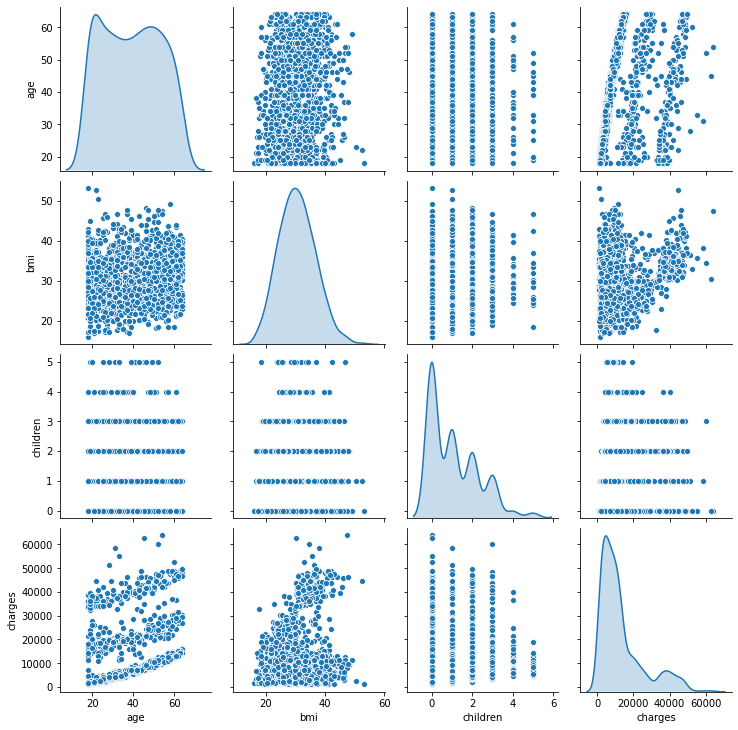

In [126]:
#histogram to see distribution of data points
sns.pairplot(data=df, diag_kind='kde')
plt.show()

**Gender**

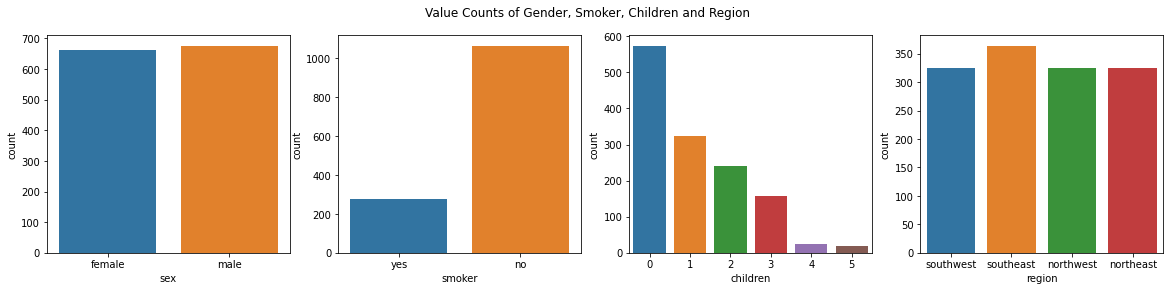

In [127]:
fig, ax2 = plt.subplots(1,4,  figsize=(20,4))
fig.suptitle('Value Counts of Gender, Smoker, Children and Region')
sns.countplot(ax=ax2[0], x=df.sex)
sns.countplot(ax=ax2[1], x=df.smoker)
sns.countplot(ax=ax2[2], x=df.children)
sns.countplot(ax=ax2[3], x=df.region)
plt.show()

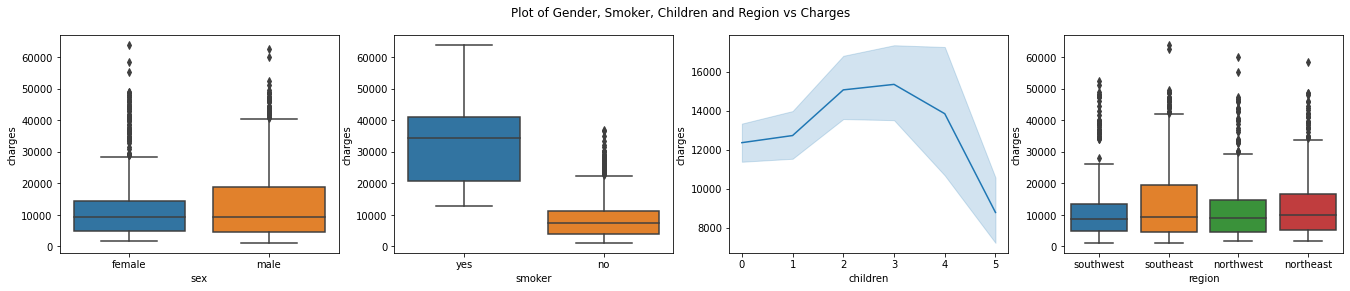

In [128]:
fig, ax2 = plt.subplots(1,4,  figsize=(23,4))
fig.suptitle('Plot of Gender, Smoker, Children and Region vs Charges',)
sns.boxplot(ax=ax2[0], x=df.sex, y=df.charges)
sns.boxplot(ax=ax2[1], x=df.smoker, y=df.charges)
sns.lineplot(ax=ax2[2], x=df.children, y=df.charges)
sns.boxplot(ax=ax2[3], x=df.region, y=df.charges)
plt.show()

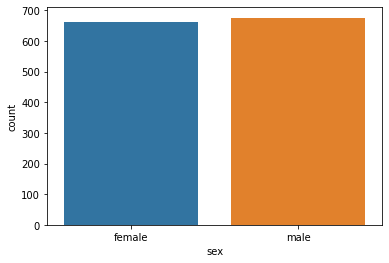

In [129]:
#Count of males vs females
sns.countplot(df.sex)
plt.show()

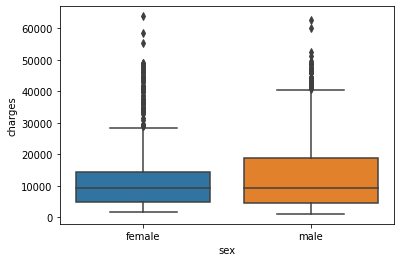

In [130]:
#Box Plot for Gender vs  charges
sns.boxplot(x=df.sex, y=df.charges)
plt.show()

Percentage of males and females are almost the same and On average median charges of male and female are also same, but males have higher range of charges.

**Children**

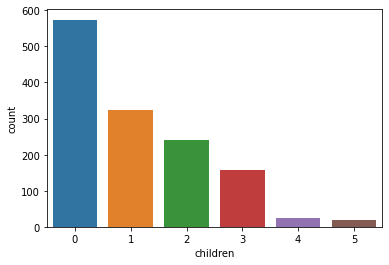

In [131]:
sns.countplot(df.children)
plt.show()

Most of the people do not have children

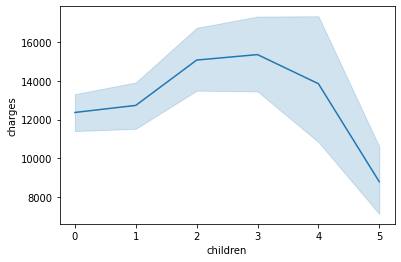

In [132]:
sns.lineplot(df.children, df.charges)
plt.show()

Charges are highest for people with 2-3 children

**Smoker**

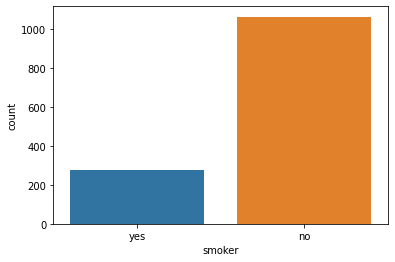

In [133]:
sns.countplot(df.smoker)
plt.show()

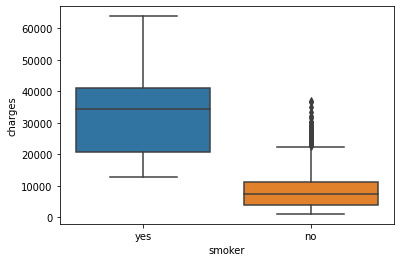

In [134]:
sns.boxplot(x=df.smoker, y=df.charges)
plt.show()

Percentage of smokers is less but insurance charges are relatively higher for them

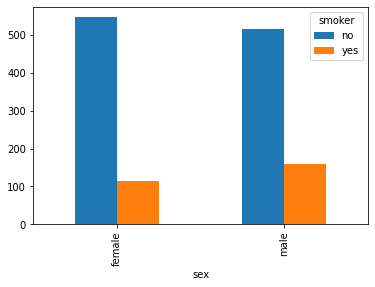

In [135]:
pd.crosstab(df.sex, df.smoker).plot(kind="bar")
plt.show()

Percentage of female smokers is less than the percentage of male smokers

**Region**

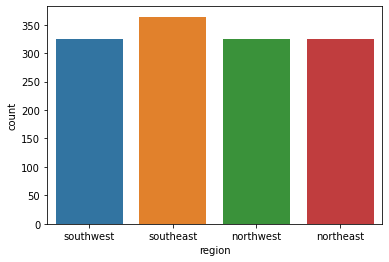

In [136]:
sns.countplot(df.region)
plt.show()

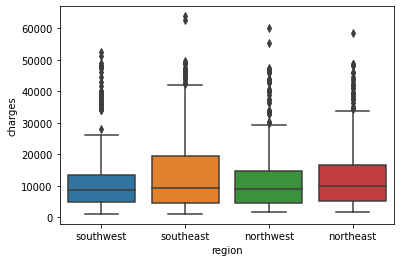

In [137]:
sns.boxplot(x=df.region, y=df.charges)
plt.show()

Regions are equally distributed and all 4 regions have almost the same charges.

##### Correlation analysis

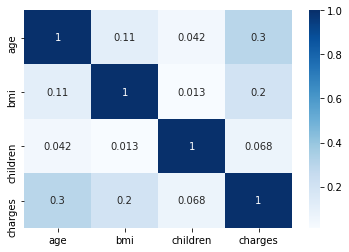

In [138]:
#Correlation map between charges and numeric features - age, bmi and charges
sns.heatmap(df[['age', 'bmi', 'children', 'charges']].corr(), cmap='Blues', annot=True)
plt.show()

Age and charges are strongly co-related 

##### Feature Selection, Transformation, Scaling 

In [139]:
#Converting categorical variables to numeric form - One hot encoding
region=pd.get_dummies(df.region, prefix='location')
df = pd.concat([df,region],axis=1)
df.drop(columns='region', inplace=True)

In [140]:
df.sex.replace(to_replace=['male', 'female'], value=[1,0], inplace=True)
df.smoker.replace(to_replace=['yes', 'no'], value=[1,0], inplace=True)
df.sample(3)

,age,sex,bmi,children,smoker,charges,location_northeast,location_northwest,location_southeast,location_southwest
739,29.0,1,35.500,2,1,44585.45587,0,0,0,1
1107,50.0,0,26.220,2,0,10493.94580,0,1,0,0
528,46.0,1,39.425,1,0,8342.90875,1,0,0,0


Based on the map, Smoker has a considerable impact on the insurance charges, while sex has the least impact and so we will drop this column in our feature list(X). We will now proceed towards model development where the first step is to select X and Y and split data into test and train sets

In [141]:
#Creating and X and Y variables region_rank
y=df.charges.values
X=df[['age', 'bmi', 'smoker', 'children', 'location_northeast', 'location_northwest', 'location_southeast', 'location_southwest']]

#Split data into test and train
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [142]:
from sklearn.preprocessing import RobustScaler, StandardScaler
numeric=['age', 'bmi', 'children']
sc=StandardScaler()
X_train[numeric]=sc.fit_transform(X_train[numeric])
X_test[numeric]=sc.transform(X_test[numeric])

##### Model Development

We will run a number of regression algorithms and evaluate root mean squared error , mean absolute error metrics for each of these models. These would be our baseline models.

In [143]:
model = LinearRegression()
model.fit(X_train, y_train)
yhat = model.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))


(0.7822886963985674, 4239.332244958955, 5813.725459250961)

In [144]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=1)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

(0.7720612514928122, 2740.9521598843285, 5948.714278191823)

In [145]:
sc={'Name':['Linear', 'DecisionTrees'], 'MAE':[4239, 2740], 'RMSE':[5813, 5984], 'R2_score':[0.782, 0.773]}
pd.DataFrame(sc)

,Name,MAE,RMSE,R2_score
0,Linear,4239,5813,0.782
1,DecisionTrees,2740,5984,0.773


##### Feature Engineering

1. Grouping similar customers into clusters using KMeans.
2. Clubbing northeast and northwest regions into 'north' and southeast and southwest into 'south' in Region column.
3. Transforming 'children' into a categorical feature called 'more_than_one_child' which is 'Yes' if the number of children is > 1

In [147]:
from sklearn.cluster import KMeans
features=['age', 'bmi', 'smoker', 'children', 'location_northeast', 'location_northwest', 'location_southeast', 'location_southwest', 'sex']
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[features])

#df['cust_type'] = kmeans.predict(df[features])
df['cust_type'] = kmeans.labels_

Using point biserial test to check relation between categorical variables and charges

In [148]:
from scipy.stats import pointbiserialr
cat=['sex', 'smoker', 'location_northeast', 'location_northwest', 'location_southeast', 'location_southwest', 'cust_type']
for i in cat:
    print(i, pointbiserialr(df[i], df.charges))

sex PointbiserialrResult(correlation=0.0572920622020253, pvalue=0.03613272100594507)
smoker PointbiserialrResult(correlation=0.7872514304984779, pvalue=8.271435842164614e-283)
location_northeast PointbiserialrResult(correlation=0.006348771280156071, pvalue=0.8165263815343915)
location_northwest PointbiserialrResult(correlation=-0.03990486404043807, pvalue=0.14459698799369963)
location_southeast PointbiserialrResult(correlation=0.07398155156575983, pvalue=0.006782698910660704)
location_southwest PointbiserialrResult(correlation=-0.04321002899168482, pvalue=0.1141465936188735)
cust_type PointbiserialrResult(correlation=0.2580516038924886, pvalue=8.531251875580974e-22)


In [149]:
df['more_than_1_child']=df.children.apply(lambda x:1 if x > 1 else 0 )

In [150]:
def get_north(a,b):
    if ((a == 1) | (b == 1)):
        return 1
    else:
        return 0

In [151]:
def get_south(a,b):
    if ((a == 1) | (b == 1)):
        return 1
    else:
        return 0

In [152]:
df['location_north']=df.apply(lambda x: get_north(x['location_northeast'], x['location_northwest']), axis=1)
df['location_south']=df.apply(lambda x: get_south(x['location_southwest'], x['location_southeast']), axis=1)

df.sample(3)

,age,sex,bmi,children,smoker,charges,location_northeast,location_northwest,location_southeast,location_southwest,cust_type,more_than_1_child,location_north,location_south
262,52.0,1,24.32,3,1,24869.8368,1,0,0,0,1,1,1,0
101,30.0,1,25.46,0,0,3645.0894,1,0,0,0,0,0,1,0
108,29.0,1,27.94,0,0,2867.1196,0,0,1,0,0,0,0,1


In [153]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'location_northeast', 'location_northwest', 'location_southeast',
       'location_southwest', 'cust_type', 'more_than_1_child',
       'location_north', 'location_south'],
      dtype='object')

p=df[['age', 'bmi', 'smoker', 'location_northeast', 'location_northwest', 'location_southeast',
       'location_southwest', 'cust_type', 'more_than_1_child',
       'location_north', 'location_south']]
q=df.charges

###### Create and fit selector
KBest = SelectKBest(f_regression, k=7)
KBest.fit(p,q)
###### Get columns to keep and create new dataframe with those only
cols = KBest.get_support(indices=True)
features_df_new = p.iloc[:,cols]
features_df_new[0:2]

In [154]:
#Table to record metrics of various models
metrics=pd.DataFrame()
Model=[]
rmse=[]
mae=[]
r2=[]

In [155]:
#Selecting X and Y 
y=df.charges.values
X=df[['age', 'bmi', 'smoker', 'more_than_1_child', 'cust_type', 'location_north', 'location_south']]  #--> works well #imp


#Split test and train data
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [156]:
from sklearn.preprocessing import RobustScaler, StandardScaler
numeric=['age', 'bmi']
#sc=MinMaxScaler()  #Using MinMax scalar to standardize data
#sc=RobustScaler()
sc=StandardScaler()
X_train[numeric]=sc.fit_transform(X_train[numeric])
X_test[numeric]=sc.transform(X_test[numeric])

In [157]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

model = LinearRegression()
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))


(0.7321086635115455, 3281.000099531603, 6449.014666402026)

In [158]:
model = DecisionTreeRegressor()
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)
round(r2_score(y_test, yhat), 3), round(mean_absolute_error(y_test, yhat), 2), round(np.sqrt(mean_squared_error(y_test, yhat)),2)


(0.84, 2240.34, 4976.68)

In [159]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
p=PolynomialFeatures(degree=3)
X_train_poly=p.fit_transform(X_train)
X_test_poly=p.fit_transform(X_test)

model = RandomForestRegressor()
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train_poly, y_train)
yhat = regr_trans.predict(X_test_poly)
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))


(0.8816126128104302, 2041.2454586363817, 4287.130938728854)

In [160]:
from sklearn.ensemble import GradientBoostingRegressor
def boost_models(x):
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, y_train)
    yhat = regr_trans.predict(X_test)
    algoname= x.__class__.__name__
    return algoname, round(r2_score(y_test, yhat),3), round(mean_absolute_error(y_test, yhat),1), round(np.sqrt(mean_squared_error(y_test, yhat)),1)

In [161]:
algo=[GradientBoostingRegressor(), lgbm.LGBMRegressor(), xg.XGBRFRegressor()]
score=[]
for a in algo:
    score.append(boost_models(a))
pd.DataFrame(score, columns=['Model', 'Score', 'MAE', 'RMSE'])

,Model,Score,MAE,RMSE
0,GradientBoostingRegressor,0.878,2055.3,4357.7
1,LGBMRegressor,0.862,2296.1,4632.5
2,XGBRFRegressor,0.881,2015.9,4289.3


In [162]:
from sklearn.model_selection import GridSearchCV

In [163]:
param_grid = {'n_estimators': [100, 80, 60, 50, 45],  
              'max_depth': [3, 4, 5, 6],
              'learning_rate' :[0.2, 0.15]
             }
                
grid = GridSearchCV(GradientBoostingRegressor(), param_grid, refit = True, verbose = 0, n_jobs=-1) #
regr_trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution='normal'))

# fitting the model for grid search 
grid_result=regr_trans.fit(X_train, y_train)
best_params=grid_result.regressor_.best_params_
print(best_params)

#using best params to create and fit model
best_model = GradientBoostingRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], learning_rate=best_params["learning_rate"])
regr_trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)

#evaluate metrics
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 45}


(0.8769566256504228, 2092.2844483253944, 4370.620984052413)

In [164]:
param_grid = {'n_estimators': [100, 80, 60, 50, 45],  
              'max_depth': [3, 4, 5, 6],
              'num_leaves' :[9, 10, 11, 12]
             }
                
grid = GridSearchCV(lgbm.LGBMRegressor(), param_grid, refit = True, verbose = 3, n_jobs=-1) #
regr_trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution='normal'))

# fitting the model for grid search 
grid_result=regr_trans.fit(X_train, y_train)
best_params=grid_result.regressor_.best_params_
print(best_params)

#using best params to create and fit model
best_model = lgbm.LGBMRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], num_leaves=best_params["num_leaves"])
regr_trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)

#evaluate metrics
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    5.1s


{'max_depth': 3, 'n_estimators': 50, 'num_leaves': 9}


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   10.1s finished


(0.8789938161471642, 2034.480299396168, 4334.2884705350525)

In [165]:
param_grid = {'n_estimators': [100, 80, 60, 50, 45],  
              'max_depth': [None, 3, 4, 5, 6]
              
              
             }
                
grid = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3, n_jobs=-1) #
regr_trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution='normal'))

# fitting the model for grid search 
grid_result=regr_trans.fit(X_train, y_train)
best_params=grid_result.regressor_.best_params_
print(best_params)

#using best params to create and fit model
best_model = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"])
regr_trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)

#evaluate metrics
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   18.1s finished


{'max_depth': 5, 'n_estimators': 100}


(0.8787904301639744, 2062.516874304508, 4337.92945559359)

In [166]:
param_grid = {'n_estimators': [100, 80, 60, 55, 51, 45],  
              'max_depth': [7, 8],
              'reg_lambda' :[0.26, 0.25, 0.2]
             }
                
grid = GridSearchCV(xg.XGBRFRegressor(), param_grid, refit = True,  n_jobs=-1) #
regr_trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution='normal'))

# fitting the model for grid search 
grid_result=regr_trans.fit(X_train, y_train)
best_params=grid_result.regressor_.best_params_
print(best_params)

#using best params to create and fit model
best_model = xg.XGBRFRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], reg_lambda=best_params["reg_lambda"])
regr_trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)

#evaluate metrics
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

{'max_depth': 7, 'n_estimators': 51, 'reg_lambda': 0.26}


(0.8859892161387841, 1977.9098029441752, 4207.140307957002)

********************************

In [167]:
model = RandomForestRegressor(n_estimators = 120) 

regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)

Model.append("RandomForest Regression")
rmse.append(round(np.sqrt(mean_squared_error(y_test, yhat)),3))
mae.append(round(mean_absolute_error(y_test, yhat),3))
r2.append(round(r2_score(y_test, yhat),3))

0.8822274316383789

In [168]:
model = xg.XGBRFRegressor(n_estimators = 51, max_depth=7, reg_lambda=0.27)  #n_estimators = 51, max_depth=7, reg_lambda=0.27

regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)

Model.append("XGBoost Regression")
rmse.append(round(np.sqrt(mean_squared_error(y_test, yhat)),3))
mae.append(round(mean_absolute_error(y_test, yhat),3))
r2.append(round(r2_score(y_test, yhat),3))


In [170]:
model = lgbm.LGBMRegressor(n_estimators = 50, max_depth=5,  num_leaves=11)   #n_estimators = 50, max_depth=5,  num_leaves=11
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)

Model.append("Light GBM Regression")
rmse.append(round(np.sqrt(mean_squared_error(y_test, yhat)),3))
mae.append(round(mean_absolute_error(y_test, yhat),3))
r2.append(round(r2_score(y_test, yhat),3))

#sns.barplot(x=regr_trans.feature_importances_, y=['age', 'bmi', 'smoker', 'children', 'location_northeast', 'location_northwest', 'location_southeast','location_southwest'])
#plt.show()

#### Metrics Table

In [171]:
metrics['Model']=Model
metrics['rmse']=rmse
metrics['mae']=mae
metrics['r2']=r2
metrics

,Model,rmse,mae,r2
0,RandomForest Regression,4275.984,2066.837,0.882
1,XGBoost Regression,4207.140,1977.910,0.886
2,XGBoost Regression,4211.971,1978.531,0.886
3,Light GBM Regression,4342.913,2023.112,0.879


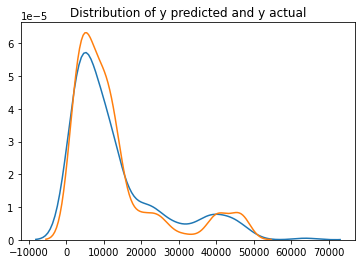

In [172]:
plt.title("Distribution of y predicted and y actual")
ax1=sns.distplot(y_test, hist=False)
sns.distplot(yhat, hist=False, ax=ax1)
plt.show()

<AxesSubplot:>

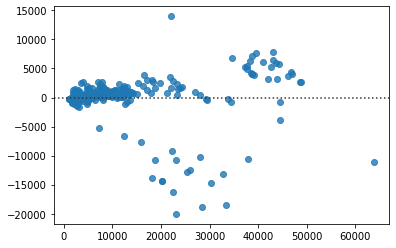

In [173]:
sns.residplot(y_test,yhat)